# Navagation 

This notebook is the first project of Deep Reinforcement Learnig Nanodgree(@udacity).


 - Experience Replay, Dueling Network and DDQN implemented in the Unity environment.
 -  Please note that the code from the DQN lecture was used as the source.
 
 

All you have to do is run the code cells one by one. You'll see an untained agent become an expert in picking only sweet yellow bananas.

### 1. Start the Environment
- Please set up the environment by following the [instructions in the DRLND GitHub repository](https://github.com/udacity/deep-reinforcement-learning#dependencies)

- Then, install [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

Let's import all the modules we need for this program.

In [1]:
import os
import random
import numpy as np
from unityagents import UnityEnvironment
from collections import namedtuple, deque
import matplotlib.pyplot as plt
%matplotlib inline

Sure you like Pytorch

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

This notebook placed in the same folder as *'banana.exe'* runs fine on **windows10**. It can't be guaranteed the nice results on other operating systems.

Let's start the Environment!

In [3]:
env = UnityEnvironment(file_name="Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In environments, the difference between unity and gym seems to be ***brains***. It is associated in determining agent behavior. 

Let's make the first ***brain*** available, and set it as the default one.



In [4]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Action: 4 types
- `0` - walk forward
- `1` - walk backward
- `2` - turn left
- `3` - turn right

State : 37 dimensions
- `0`  velocity, `1`, `2`, `3`....... `36`, `37` Ray based recognition

Reward : 2 types
- `+1` - yellow banana
- `-1` - blue banana

Please run the cell below. Then, check the information printed by the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name]
print('Number of agents:', len(env_info.agents))

action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment
Running the next code cell, you can see the interaction with environment and agent through game video. There will be green and yellow bananas everywhere, and the agent will move randomly. Agent knows nothing like a baby. We will train baby agents and raise them as skilled banana pickers.

In [6]:
env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations[0]
score = 0  
while True:
    action = np.random.randint(action_size)
    env_info = env.step(action)[brain_name]
    next_state = env_info.vector_observations[0]
    reward = env_info.rewards[0]
    done = env_info.local_done[0]
    score += reward
    state = next_state
    if done:
        break
    
print("Score: {}".format(score))

Score: 0.0


### 4. Dueling Network
The following code cell is a neural network approximating action value functions. The difference from DQN model is that the one of hidden layer(fourth) is divided into two parts and trained separately. Eventually, they add up to each other and calculate the Q-function. It is relatively more efficient than DQN.

In [7]:
class DuelingNetwork(nn.Module):
    
    def __init__(self, state_size, action_size, seed=2, fc1_units=64, fc2_units=64, fc3_units=64):
        super(DuelingNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, fc3_units)
        
        # This hiddenlayer divided into two 
        self.fc4_adv = nn.Linear(fc3_units, action_size) # Advantage part
        self.fc4_v = nn.Linear(fc3_units, 1) # V(s)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        
        # Advantage function
        adv = self.fc4_adv(x)
        
        # V(s)
        val = self.fc4_v(x).expand(-1, adv.size(1))                       
        
        # V(s) +  Advantage - Average(Advantage)
        output = val + adv - adv.mean(1, keepdim=True).expand(-1, adv.size(1))
        
        return output

### 5. DDQN and Experience Replay

- **DDQN**: 
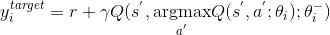

There are two networks used for training DDQN. In the Agent Class, these are the *qnetwork_target* and *qnetwork_local* . In the next state, the maximum action is obtained from *qnetwork_local*, and the Q-value at this time-step is come from *qnetwork_target*.


- **Experience Replay**:

It stores the experience of each time-step into memory. Then, the previous contents from this memory are randomly replayed. It trains using this transition.

In [8]:
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 64
GAMMA = 0.99
TAU = 1e-3
LR = 5e-4
UPDATE_EVERY = 4

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class Agent():
    
    def __init__(self, state_size, action_size, seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.qnetwork_local = DuelingNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = DuelingNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)
        self.t_step = 0
        
        # Memory for experience replay
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
           
    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        # Get action maximizing Q values from local network
        max_actions = self.qnetwork_local(next_states).max(1)[1].unsqueeze(1)
        
        # Get Q values from target network for next state
        TargetQnext = self.qnetwork_target(next_states).detach().gather(1, max_actions)
        
        # Compute Q values as targets
        TargetQ = rewards + (gamma * TargetQnext * (1 - dones))

        # Get expected Q values from local_network
        ExpectedQ = self.qnetwork_local(states).gather(1, actions)
        
        # TD loss
        Loss = F.mse_loss(ExpectedQ, TargetQ)
        self.optimizer.zero_grad()
        Loss.backward()
        self.optimizer.step()
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)
            

            
# Experience replay           
class ReplayBuffer:
    
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.memory)            

### 6. Train Dueling DDQN

The following cell define a function for training. First, create an agent object. After this, It repeats for 800 episodes. One episode is up to 500 timesteps max. As the trainig progresses, the agent gains experience towards increase rewards. Based on this experience, the agent inclines using its own action rather than random one.

It will be acheived our mission when average scores reach at 13. Also, if it reahces around 15, our training will be completed.

In [9]:
# call Agent class
agent = Agent(state_size=37, action_size=4, seed=2)

def Dueling_DDQN(n_episodes=800, max_t=500, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    for i_episode in range(1, n_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = (int) (agent.act(state, eps))
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_decay * eps)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            
        if np.mean(scores_window) >= 15.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode - 100,
                                                                                         np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'Model.pth')
            break
    return scores

Finally, training begins.

In [10]:
scores = Dueling_DDQN()

Episode 100	Average Score: 0.66
Episode 200	Average Score: 3.95
Episode 300	Average Score: 6.89
Episode 400	Average Score: 11.09
Episode 500	Average Score: 13.78
Episode 547	Average Score: 15.01
Environment solved in 447 episodes!	Average Score: 15.01


Enjoy the beautiful rising curves.

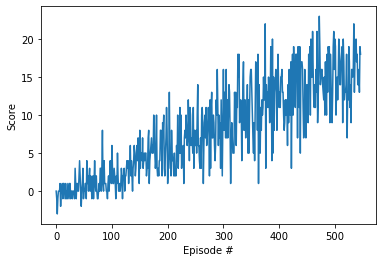

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 7. Let's look at the smart agent we trained
It is stored in *Checkpoint.pth* trained weights. Let's load this file now.

In [12]:
agent.qnetwork_local.load_state_dict(torch.load('Model.pth'))

Let's appreciate how well our agents are trained.

In [13]:
for i in range(3):
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0]
    score = 0 
    for i in range(300):
        action = (int)(agent.act(state,0.01))
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        score += reward
        state = next_state 
        if done:                                     
            break
    
print("Score: {}".format(score))

Score: 0.0


Close the unity environment.

In [14]:
env.close()

### 8. Result

- This notebook works well in environments without a GPU.
- Dueling DDQN was about 300episodes faster than DQN under similar conditions.
- Using Prioritized Experienced Replay will be more efficient.
- It would be more interesting to implement a CNN model that accepts input in pixels.


Good job to read and wish you success!